In [143]:
# read sentiment score from txt
path = "../data/Data_Set_S1.txt"
with open(path, 'r') as f:
    sentiment_score = f.read().strip()
print(f"Sentiment score: {sentiment_score}")

Sentiment score: labMIT-1.0.txt
language assessment by Mechanical Turk 1.0

word	happiness_rank	happiness_average	happiness_standard_deviation	twitter_rank	google_rank	nyt_rank	lyrics_rank
laughter	1	8.50	0.9313	3600	--	--	1728
happiness	2	8.44	0.9723	1853	2458	--	1230
love	3	8.42	1.1082	25	317	328	23
happy	4	8.30	0.9949	65	1372	1313	375
laughed	5	8.26	1.1572	3334	3542	--	2332
laugh	6	8.22	1.3746	1002	3998	4488	647
laughing	7	8.20	1.1066	1579	--	--	1122
excellent	8	8.18	1.1008	1496	1756	3155	--
laughs	9	8.18	1.1551	3554	--	--	2856
joy	10	8.16	1.0568	988	2336	2723	809
successful	11	8.16	1.0759	2176	1198	1565	--
win	12	8.12	1.0812	154	3031	776	694
rainbow	13	8.10	0.9949	2726	--	--	1723
smile	14	8.10	1.0152	925	2666	2898	349
won	15	8.10	1.2164	810	1167	439	1493
pleasure	16	8.08	0.9655	1497	1526	4253	1398
smiled	17	8.08	1.0660	--	3537	--	2248
rainbows	18	8.06	1.3603	--	--	--	4216
winning	19	8.04	1.0490	1876	--	1426	3646
celebration	20	8.02	1.5318	3306	--	2762	4070
enjoyed	21	8.02	1.5318	15

In [144]:
import os
import io
import numpy as np
import requests
import pandas as pd
# Fetch sentimantal scores from dataset
local_sentiment_data = "data/Data_Set_S1.txt"
raw_sentiment_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_sentiment_data}"

if os.path.exists(local_sentiment_data):
    df = pd.read_csv(local_sentiment_data, sep="\t", skiprows=2, header=0)
else:
    r = requests.get(raw_sentiment_url, timeout=30)
    r.raise_for_status()
    with io.StringIO(r.text) as fh:
        df = pd.read_csv(fh, sep="\t", skiprows=2, header=0)

df["word"] = df["word"].astype("string")
for col in ["twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]:
    df[col] = df[col].replace("--", np.nan)
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
    
df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,<NA>,<NA>,1728
1,happiness,2,8.44,0.9723,1853,2458,<NA>,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,<NA>,2332


In [145]:
word_to_happiness_avg = dict(zip(df["word"], df["happiness_average"]))

def sentiment_score(text: str):
    tokens_lower = text.lower().split()
    scores = [
        word_to_happiness_avg[token] for token in tokens_lower if token in word_to_happiness_avg
    ]
    if scores:
        return sum(scores) / len(scores)
    return None

print("Sentiment dataset statistics:")
print(f"Total words with sentiment scores: {len(word_to_happiness_avg)}")
print(f"Dataset min sentiment score: {min(word_to_happiness_avg.values())}")
print(f"Dataset max sentiment score: {max(word_to_happiness_avg.values())}")
print(f"Dataset mean sentiment score: {np.mean(list(word_to_happiness_avg.values())):.4f}")
print(f"Dataset percentiles (25%, Median, 75%):", np.percentile(list(word_to_happiness_avg.values()), [25, 50, 75]))

Sentiment dataset statistics:
Total words with sentiment scores: 10222
Dataset min sentiment score: 1.3
Dataset max sentiment score: 8.5
Dataset mean sentiment score: 5.3752
Dataset percentiles (25%, Median, 75%): [4.9  5.44 6.02]


In [146]:
from bs4 import BeautifulSoup
import re
import json
from collections import defaultdict
from pathlib import Path

# Set up data directory
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

In [147]:
# Setup scripts dictionary
scripts = {}
for movie in ["A New Hope", "The Empire Strikes Back", "Return of the Jedi"]:
    script_file = DATA_DIR / f"html/Star-Wars-{movie.replace(' ', '-')}.html"
    with open(script_file, "r", encoding="utf-8", errors="replace") as f:
        scripts[movie] = f.read()

In [148]:
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already present
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))


def fetch_script_from_file(file_path):
    """Load a Star Wars script from local HTML file"""
    print(f"Loading: {file_path}")
    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
        return f.read()


def extract_scenes_and_characters(html_content):
    """Extract scene headings and character names from script HTML"""
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Find the table with class="scrtext" which marks the start of the actual script
    script_table = soup.find("td", class_="scrtext")
    if not script_table:
        print("Warning: Could not find scrtext table in HTML")
        return [], {}, {}, {}, {}
    
    # Find the pre tag within the script table
    pre_tag = script_table.find("pre")
    if not pre_tag:
        print("Warning: Could not find pre tag in script table")
        return [], {}, {}, {}, {}
    
    script_text = pre_tag.get_text()
    lines = script_text.split("\n")
    
    scenes = []
    # Track all dialogue per location and character
    location_dialogues = {}  # location -> list of dialogue lines
    character_dialogues = {}  # character -> list of dialogue lines
    
    current_scene = {"location": None, "characters": set(), "content": []}
    current_location = None
    current_speaking_character = None  # Track who is currently speaking
    scene_started = False  # Track if we've reached the actual script content
    
    for line in lines:
        line_stripped = line.strip()
        
        # Skip empty lines
        if not line_stripped:
            continue
        
        # Detect scene headings
        # Format 1: "INT. LOCATION" or "EXT. LOCATION"
        # Format 2 (Return of the Jedi): "1    INT LOCATION" or "3    EXT LOCATION"
        # Format 3 (Return of the Jedi special): "1    SPACE" or "19   HOLDING TUNNEL"
        is_scene_heading = False
        
        # Check for numbered scene format (any line starting with number + spaces + capital letter)
        # This catches both "3    INT DEATH STAR" and "1    SPACE"
        if re.match(r"^[0-9]+\s+[A-Z]", line_stripped):
            is_scene_heading = True
            scene_started = True
        # Check for standard format (e.g., "INT. DEATH STAR")
        elif re.match(r"^(INT|EXT)\.\s+", line_stripped):
            is_scene_heading = True
            scene_started = True
        
        if is_scene_heading:
            # Save previous scene if it has a location (even with 0 characters)
            if current_scene["location"] is not None:
                scenes.append(current_scene)
            
            current_location = line_stripped
            current_speaking_character = None  # Reset current speaker
            current_scene = {
                "location": current_location,
                "characters": set(),
                "content": [],
            }
            
            # Initialize location dialogue list if new
            if current_location not in location_dialogues:
                location_dialogues[current_location] = []
        
        # Detect character names - all caps, possibly with spaces/hyphens/apostrophes
        # Only process after we've started seeing actual scenes
        elif (
            scene_started
            and re.match(r"^[A-Z][A-Z\s\-\']*$", line_stripped)
            and len(line_stripped) > 1
            and len(line_stripped) < 50
        ):
            # This is likely a character name
            char_name = line_stripped.strip()
            # Filter out common non-character all-caps text
            if char_name and char_name not in [
                "FADE IN:",
                "FADE OUT:",
                "THE END",
                "CREDITS",
                "TO BE CONTINUED",
                "CUT TO:",
                "DISSOLVE TO:",
                "CONTINUED:",
            ]:
                current_speaking_character = char_name  # Set as current speaker
                current_scene["characters"].add(char_name)
                current_scene["content"].append(("CHARACTER", char_name))
                
                # Initialize character dialogue list if new
                if char_name not in character_dialogues:
                    character_dialogues[char_name] = []
        
        # Handle dialogue and action lines
        else:
            if scene_started:
                # Skip stage directions (lines in parentheses like "(over comlink)")
                # But only if they're JUST parentheses content
                if line_stripped.startswith("(") and line_stripped.endswith(")"):
                    current_scene["content"].append(("STAGE_DIRECTION", line_stripped))
                    continue
                
                # This is either dialogue or action description
                current_scene["content"].append(("DIALOGUE", line_stripped))
                
                # Add ALL content to location (dialogue + action descriptions)
                if current_location:
                    location_dialogues[current_location].append(line_stripped)
                
                # Only add actual dialogue to the currently speaking character
                # We determine it's dialogue if there's a current speaker
                if current_speaking_character:
                    character_dialogues[current_speaking_character].append(line_stripped)
                else:
                    # If no current speaker, this is action description, not dialogue
                    # Don't add to any character, but it's already added to location above
                    pass
    
    # # Don't forget the last scene
    # if current_scene["location"] is not None:
    #     scenes.append(current_scene)

    
    return scenes, location_sentiments, character_sentiments, location_dialogues, character_dialogues
# Load all three scripts from local files
scripts = {}
scripts["A New Hope"] = fetch_script_from_file(
    DATA_DIR / "html" / "Star-Wars-A-New-Hope.html"
)
scripts["The Empire Strikes Back"] = fetch_script_from_file(
    DATA_DIR / "html" / "Star-Wars-The-Empire-Strikes-Back.html"
)
scripts["Return of the Jedi"] = fetch_script_from_file(
    DATA_DIR / "html" / "Star-Wars-Return-of-the-Jedi.html"
)

print("Scripts loaded successfully!")



Loading: data/html/Star-Wars-A-New-Hope.html
Loading: data/html/Star-Wars-The-Empire-Strikes-Back.html
Loading: data/html/Star-Wars-Return-of-the-Jedi.html
Scripts loaded successfully!


In [149]:
# Extract scenes from each script
all_scenes = {}
all_location_sentiments_by_movie = {}
all_character_sentiments_by_movie = {}

# Track character connections and location-character relationships
character_connections = {}      # character -> {other_character: count}
location_characters = {}        # location -> set of characters

all_character_dialogues = {}    # {movie: {character: [lines]}}
all_location_dialogues = {}     # {movie: {location: [lines]}}

for title, html in scripts.items():
    print(f"\nParsing {title}...")

    scenes, location_sentiments, character_sentiments, location_dialogues, character_dialogues = \
        extract_scenes_and_characters(html)

    # store dialogues per movie
    all_character_dialogues[title] = character_dialogues
    all_location_dialogues[title] = location_dialogues

    # store scenes + per-movie sentiments
    all_scenes[title] = scenes
    all_location_sentiments_by_movie[title] = location_sentiments
    all_character_sentiments_by_movie[title] = character_sentiments

    # Build character co-appearance graph
    for scene in scenes:
        characters = list(scene["characters"])
        location = scene["location"]

        # Track which characters appear in each location
        if location:
            location_characters.setdefault(location, set()).update(characters)

        # Track co-appearances
        for i, char1 in enumerate(characters):
            character_connections.setdefault(char1, {})

            for char2 in characters[i + 1:]:
                character_connections[char1][char2] = character_connections[char1].get(char2, 0) + 1
                character_connections.setdefault(char2, {})
                character_connections[char2][char1] = character_connections[char2].get(char1, 0) + 1

    print(f"  Found {len(scenes)} scenes with character interactions")
    print(f"  Analyzed {len(location_sentiments)} unique locations")
    print(f"  Analyzed {len(character_sentiments)} unique characters")


# -----------------------------------------
# MERGE DIALOGUES ACROSS MOVIES
# -----------------------------------------

merged_character_dialogues = {}

for movie, chars in all_character_dialogues.items():
    for character, lines in chars.items():
        merged_character_dialogues.setdefault(character, []).extend(lines)

merged_location_dialogues = {}

for movie, locs in all_location_dialogues.items():
    for location, lines in locs.items():
        merged_location_dialogues.setdefault(location, []).extend(lines)


# -----------------------------------------
# SAVE MERGED DIALOGUE JSON
# -----------------------------------------

with open("data/character_dialogues_merged.json", "w", encoding="utf-8") as f:
    json.dump(merged_character_dialogues, f, indent=2)

with open("data/location_dialogues_merged.json", "w", encoding="utf-8") as f:
    json.dump(merged_location_dialogues, f, indent=2)


# -----------------------------------------
# GLOBAL SENTIMENT RECOMPUTATION (ALL MOVIES)
# -----------------------------------------

global_character_sentiments = {}

for character, lines in merged_character_dialogues.items():
    full_text = " ".join(lines) if lines else ""
    score = sentiment_score(full_text) if full_text else None
    global_character_sentiments[character] = score

global_location_sentiments = {}

for location, lines in merged_location_dialogues.items():
    full_text = " ".join(lines) if lines else ""
    score = sentiment_score(full_text) if full_text else None
    global_location_sentiments[location] = score


# -----------------------------------------
# FINAL OUTPUT VARIABLES
# -----------------------------------------

location_sentiments = global_location_sentiments
character_sentiments = global_character_sentiments
location_dialogues = merged_location_dialogues
character_dialogues = merged_character_dialogues



Parsing A New Hope...
  Found 478 scenes with character interactions
  Analyzed 456 unique locations
  Analyzed 138 unique characters

Parsing The Empire Strikes Back...
  Found 276 scenes with character interactions
  Analyzed 456 unique locations
  Analyzed 138 unique characters

Parsing Return of the Jedi...
  Found 136 scenes with character interactions
  Analyzed 456 unique locations
  Analyzed 138 unique characters


In [150]:
print(all_character_sentiments_by_movie)
# min max and avg
for movie, sentiments in all_character_sentiments_by_movie.items():
    scores = [s for s in sentiments.values() if s is not None]
    if scores:
        print(f"\n{movie} character sentiment stats:")
        print(f"  Min: {min(scores)}")
        print(f"  Max: {max(scores)}")
        print(f"  Avg: {np.mean(scores):.4f}")
    else:
        print(f"\n{movie} has no character sentiment scores.")

{'A New Hope': {'THREEPIO': 5.298668163112626, 'LUKE': 5.320114994704257, 'IMPERIAL OFFICER': 5.30037037037037, 'VADER': 5.290340643957041, 'REBEL OFFICER': 5.202222222222222, 'TROOPER': 5.259961977186319, 'CHIEF PILOT': 5.1866666666666665, 'CAPTAIN': 5.441333333333333, 'WOMAN': 5.506666666666667, 'FIXER': 5.2829999999999995, 'CAMIE': 5.332571428571431, 'BIGGS': 5.397336065573764, 'DEAK': 3.54, 'DAY': 4.982758620689655, 'LEIA': 5.331519589893766, 'COMMANDER': 5.145961538461542, 'SECOND OFFICER': 4.947878787878787, 'FIRST TROOPER': 5.158969072164951, 'SECOND TROOPER': 5.253043478260869, 'BERU': 5.381818181818182, 'OWEN': 5.35314878892734, 'AUNT BERU': 5.416481481481481, 'BEN': 5.31708766716193, 'TAGGE': 5.202100840336138, 'MOTTI': 5.190574712643679, 'TARKIN': 5.33179271708684, 'BARTENDER': 5.1695744680851075, 'CREATURE': 5.360808625336932, 'HUMAN': 5.300645161290324, 'HAN': 5.302268907563041, 'GREEDO': 5.381219512195125, 'SPEEDER LOT': 5.309565217391305, 'JABBA': 5.307388724035612, 'OFF

In [151]:
# min max avg of global_location_sentiments
location_scores = [s for s in global_location_sentiments.values() if s is not None]
if location_scores:
    print(f"Location Sentiments - Min: {min(location_scores):.4f}, Max: {max(location_scores):.4f}, Avg: {np.mean(location_scores):.4f}")
else:
    print("No location sentiment scores available.")
# min max avg of global_character_sentiments
character_scores = [s for s in global_character_sentiments.values() if s is not None]
if character_scores:
    print(f"Character Sentiments - Min: {min(character_scores):.4f}, Max: {max(character_scores):.4f}, Avg: {np.mean(character_scores):.4f}")
else:
    print("No character sentiment scores available.")

Location Sentiments - Min: 4.1667, Max: 6.3240, Avg: 5.2656
Character Sentiments - Min: 3.5400, Max: 6.1733, Avg: 5.3328


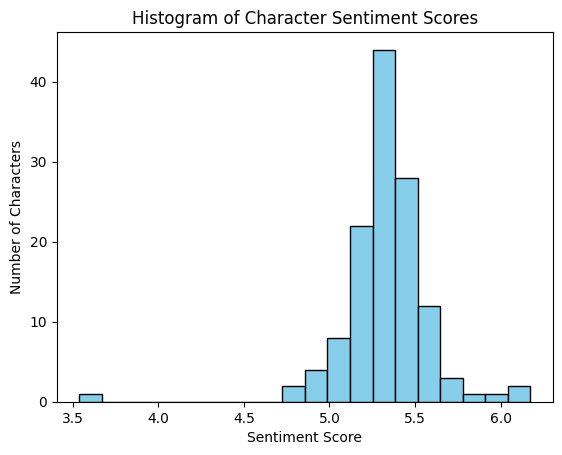

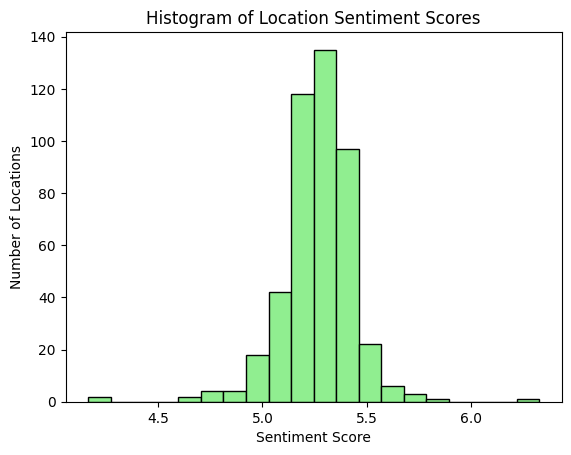

In [152]:
# plot histogram of character sentiment scores
import matplotlib.pyplot as plt
plt.hist(character_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Character Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Characters')
plt.show()
# plot histogram of location sentiment scores
plt.hist(location_scores, bins=20, color='lightgreen', edgecolor='black')
plt.title('Histogram of Location Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Locations')
plt.show()

In [153]:
# print number of different locations
print(f"Total unique locations with dialogues: {len(location_dialogues)}")
# character dialogues 
print(f"Total unique characters with dialogues: {len(character_dialogues)}")

Total unique locations with dialogues: 456
Total unique characters with dialogues: 138


In [154]:
# Character name normalization mapping
# Maps all variations of character names to canonical names
CHARACTER_NORMALIZATION = {
    # Luke
    "LUKE": "Luke Skywalker",
    "LUKE SKYWALKER": "Luke Skywalker",
    "LUKE'S VOICE": "Luke Skywalker",
    # Han Solo
    "HAN": "Han Solo",
    "HAN SOLO": "Han Solo",
    "HAN'S VOICE": "Han Solo",
    # Leia
    "LEIA": "Leia Organa",
    "LEIA ORGANA": "Leia Organa",
    "LEIA'S VOICE": "Leia Organa",
    "PRINCESS LEIA": "Leia Organa",
    # Obi-Wan
    "OBI-WAN": "Obi-Wan Kenobi",
    "OBI WAN": "Obi-Wan Kenobi",
    "OBI-WAN KENOBI": "Obi-Wan Kenobi",
    "BEN": "Obi-Wan Kenobi",
    "OLD BEN": "Obi-Wan Kenobi",
    # Yoda
    "YODA": "Yoda",
    "YODA'S VOICE": "Yoda",
    # Darth Vader
    "VADER": "Darth Vader",
    "DARTH VADER": "Darth Vader",
    "LORD VADER": "Darth Vader",
    "VADER'S VOICE": "Darth Vader",
    # Emperor Palpatine
    "EMPEROR": "Emperor Palpatine",
    "PALPATINE": "Emperor Palpatine",
    "EMPEROR PALPATINE": "Emperor Palpatine",
    "THE EMPEROR": "Emperor Palpatine",
    "EMPEROR'S VOICE": "Emperor Palpatine",
    # Lando
    "LANDO": "Lando Calrissian",
    "LANDO CALRISSIAN": "Lando Calrissian",
    # Chewbacca
    "CHEWBACCA": "Chewbacca",
    "CHEWIE": "Chewbacca",
    "CHEW": "Chewbacca",
    # C-3PO and R2-D2
    "C-3PO": "C-3PO",
    "C3PO": "C-3PO",
    "THREEPIO": "C-3PO",
    "THREE-PO": "C-3PO",
    "R2-D2": "R2-D2",
    "R2D2": "R2-D2",
    "ARTOO": "R2-D2",
    # Other characters
    "LEIA'S HANDMAIDEN": "Leia's Handmaiden",
    "REBEL GENERAL": "Rebel General",
    "IMPERIAL OFFICER": "Imperial Officer",
    "STORMTROOPER": "Stormtrooper",
    "GUARD": "Guard",
    "OFFICER": "Officer",
    "PILOT": "Pilot",
    "REBEL PILOT": "Rebel Pilot",
    "X-WING PILOT": "X-Wing Pilot",
    # Other named characters
    "WEDGE": "Wedge Antilles",
    "WEDGE ANTILLES": "Wedge Antilles",
    "UNCLE OWEN": "Owen Lars",
    "OWEN": "Owen Lars",
    "AUNT BERU": "Beru Lars",
    "BERU": "Beru Lars",
    "BIGGS": "Biggs Darklighter",
    "BIGGS DARKLIGHTER": "Biggs Darklighter",
    "TARKIN": "Grand Moff Tarkin",
    "GRAND MOFF TARKIN": "Grand Moff Tarkin",
    "MOFF TARKIN": "Grand Moff Tarkin",
    "LEA": "Leia Organa",
    "SCENE": "Scene",
    "VOICE": "Voice",
}


def normalize_character_name(name):
    """Normalize a character name to canonical form"""
    if not name or not isinstance(name, str):
        return None

    name_upper = name.upper().strip()

    # Remove common suffixes
    name_upper = re.sub(r"\s*\(V\.O\.\)\s*$", "", name_upper)
    name_upper = re.sub(r"\s*\(CONT\'D\)\s*$", "", name_upper)
    name_upper = re.sub(r"\s*O\.S\.\s*$", "", name_upper)

    if name_upper in CHARACTER_NORMALIZATION:
        return CHARACTER_NORMALIZATION[name_upper]

    # If not found, clean up the name and return it
    if (
        name_upper
        and len(name_upper) > 2
        and name_upper not in ["THE", "AND", "OR", "TO"]
    ):
        return name_upper.title()

    return None


# Test the normalization
print("Testing character name normalization:")
test_names = ["LUKE", "Han", "leia", "OBI-WAN KENOBI", "VADER", "C-3PO"]
for name in test_names:
    print(f"  {name} → {normalize_character_name(name)}")

Testing character name normalization:
  LUKE → Luke Skywalker
  Han → Han Solo
  leia → Leia Organa
  OBI-WAN KENOBI → Obi-Wan Kenobi
  VADER → Darth Vader
  C-3PO → C-3PO


In [155]:
# Location normalization mapping to merge redundant location names
LOCATION_NORMALIZATION = {
    "Darth Vader's Star Destroyer": "Vader's Star Destroyer",
    "Imperial Stardestroyer": "Imperial Star Destroyer",
    "Luke's X-Wing Fighter": "Luke's X-Wing",
    "Main Hangar Deck": "Main Hangar",
    "Red Ten's Cockpit.": "Red Ten's Cockpit",
    "Sail Barge Observation Deck": "Sail Barge",
    "Snowspeeder Cockpit": "Snowspeeder",
    "Stolen Imperial Shuttle": "Imperial Shuttle",
    "Tatooine Sea": "Tatooine",
    "Red Leader's X-Wing": "Red Leader Starship",
    "Red Leader's Cockpit": "Red Leader Starship",
    "Red Leader's Fighter": "Red Leader Starship",
    "Read Leader's Cockpit": "Red Leader Starship",
    "Read Leader's X-Wing Fighter": "Red Leader Starship",
}


def clean_location_name(location):
    """Clean and normalize location names from scene headings"""
    if not location:
        return None

    # Remove scene number prefix (Return of the Jedi format: "3    INT DEATH STAR")
    location = re.sub(r"^[0-9]+\s+", "", location).strip()

    # Remove INT/EXT prefix (if present) and time of day
    # Use optional match since some scenes like "SPACE" don't have INT/EXT
    location = re.sub(r"^(INT|EXT)[\.\s]+", "", location, flags=re.IGNORECASE).strip()
    location = re.sub(
        r"\s+[--]\s+(DAY|NIGHT|DAWN|DUSK|CONTINUOUS)$",
        "",
        location,
        flags=re.IGNORECASE,
    )

    # Remove details in parentheses
    location = re.sub(r"\s*\([^)]*\)\s*$", "", location)

    # Extract only the first part before the first dash to get the main location
    # e.g., "Asteroid Cave - Millennium Falcon - Cockpit" -> "Asteroid Cave"
    # e.g., "Death Star - Detention Area - Hallway" -> "Death Star"
    if " - " in location or " – " in location:
        location = re.split(r"\s+[-–]\s+", location)[0]

    # Clean up multiple spaces
    location = re.sub(r"\s+", " ", location).strip()

    # Convert to title case
    location = location.title()

    # Fix apostrophe capitalization issue (e.g., "Luke'S" -> "Luke's")
    location = re.sub(r"'S\b", "'s", location)

    # Apply location normalization mapping to merge redundant locations
    if location in LOCATION_NORMALIZATION:
        location = LOCATION_NORMALIZATION[location]

    return location if location else None


# Test location cleaning
print("Testing location name cleaning:")
test_locations = [
    "INT. LUKE'S HOUSE - LIVING ROOM - DAY",
    "EXT. DEATH STAR - OUTER SPACE - CONTINUOUS",
    "INT. MILLENNIUM FALCON - COCKPIT (MOVING) - NIGHT",
    "INT. ASTEROID CAVE - MILLENNIUM FALCON - COCKPIT",
    "INT. DEATH STAR - DETENTION AREA - HALLWAY",
    "INT. VADER'S STAR DESTROYER",
    "INT. DARTH VADER'S STAR DESTROYER",
    "EXT. IMPERIAL STAR DESTROYER",
    "EXT. IMPERIAL STARDESTROYER",
    "INT. LUKE'S X-WING",
    "INT. LUKE'S X-WING FIGHTER",
    "INT. MAIN HANGAR",
    "INT. MAIN HANGAR DECK",
    "1    SPACE",
    "19   HOLDING TUNNEL - RANCOR PIT",
    "3    INT DEATH STAR - CONTROL ROOM",
    "10   EXT TATOOINE - DESERT",
]
for loc in test_locations:
    print(f"  {loc}")
    print(f"    → {clean_location_name(loc)}\n")

Testing location name cleaning:
  INT. LUKE'S HOUSE - LIVING ROOM - DAY
    → Luke's House

  EXT. DEATH STAR - OUTER SPACE - CONTINUOUS
    → Death Star

  INT. MILLENNIUM FALCON - COCKPIT (MOVING) - NIGHT
    → Millennium Falcon

  INT. ASTEROID CAVE - MILLENNIUM FALCON - COCKPIT
    → Asteroid Cave

  INT. DEATH STAR - DETENTION AREA - HALLWAY
    → Death Star

  INT. VADER'S STAR DESTROYER
    → Vader's Star Destroyer

  INT. DARTH VADER'S STAR DESTROYER
    → Vader's Star Destroyer

  EXT. IMPERIAL STAR DESTROYER
    → Imperial Star Destroyer

  EXT. IMPERIAL STARDESTROYER
    → Imperial Star Destroyer

  INT. LUKE'S X-WING
    → Luke's X-Wing

  INT. LUKE'S X-WING FIGHTER
    → Luke's X-Wing

  INT. MAIN HANGAR
    → Main Hangar

  INT. MAIN HANGAR DECK
    → Main Hangar

  1    SPACE
    → Space

  19   HOLDING TUNNEL - RANCOR PIT
    → Holding Tunnel

  3    INT DEATH STAR - CONTROL ROOM
    → Death Star

  10   EXT TATOOINE - DESERT
    → Tatooine



In [157]:
from collections import defaultdict

# Process all scenes to build networks
character_connections = defaultdict(lambda: defaultdict(int))
location_characters = defaultdict(set)
total_scenes = 0
skipped_scenes = 0
scenes_for_char_network = 0

# Track dialogue for sentiment analysis with normalized names
normalized_character_dialogues = defaultdict(list)
normalized_location_dialogues = defaultdict(list)

for movie_title, scenes in all_scenes.items():
    print(f"\nProcessing {movie_title}...")
    for scene in scenes:
        total_scenes += 1
        location = clean_location_name(scene["location"])
        if not location:
            skipped_scenes += 1
            continue
        
        # Normalize all character names in this scene
        normalized_chars = set()
        for char in scene["characters"]:
            normalized = normalize_character_name(char)
            if normalized:
                normalized_chars.add(normalized)
        
        # Skip scenes with no characters
        if len(normalized_chars) == 0:
            skipped_scenes += 1
            continue
        
        # Extract dialogue from scene content
        scene_dialogues = [
            text for content_type, text in scene["content"] 
            if content_type == "DIALOGUE"
        ]
        
        # Add dialogue to normalized location
        normalized_location_dialogues[location].extend(scene_dialogues)
        
        # Add dialogue to all normalized characters in this scene
        for char in normalized_chars:
            normalized_character_dialogues[char].extend(scene_dialogues)
        
        # Add characters to location (even if only 1 character)
        for char in normalized_chars:
            location_characters[location].add(char)
        
        # Create character-to-character connections only if 2+ characters
        if len(normalized_chars) >= 2:
            scenes_for_char_network += 1
            char_list = list(normalized_chars)
            for i in range(len(char_list)):
                for j in range(i + 1, len(char_list)):
                    char1 = char_list[i]
                    char2 = char_list[j]
                    # Store bidirectional connections
                    character_connections[char1][char2] += 1
                    character_connections[char2][char1] += 1
    

# NORMALIZE global_character_sentiments and global_location_sentiments SCORES BASED ON NORMALIZED NAMES
updated = {}
for original_name, sentiment in global_character_sentiments.items():
    normalized_name = normalize_character_name(original_name)
    updated[normalized_name] = sentiment

global_character_sentiments = updated

# Normalize location sentiments
updated = {}
for original_name, sentiment in global_location_sentiments.items():
    normalized_name = clean_location_name(original_name)
    updated[normalized_name] = sentiment
global_location_sentiments = updated

normalized_character_sentiments = {}
for character, dialogues in normalized_character_dialogues.items():

    sentiment = (
        global_character_sentiments.get(character) or
        global_character_sentiments.get(character.upper()) or
        global_character_sentiments.get(character.title()) or
        None
    )

    normalized_character_sentiments[character] = sentiment


normalized_location_sentiments = {}
for location, dialogues in normalized_location_dialogues.items():

    sentiment = (
        global_location_sentiments.get(location) or
        global_location_sentiments.get(location.upper()) or
        global_location_sentiments.get(location.title()) or
        None
    )

    normalized_location_sentiments[location] = sentiment


print(f"Calculated sentiments for {len(normalized_character_sentiments)} characters")
print(f"Calculated sentiments for {len(normalized_location_sentiments)} locations")

# Show summary statistics
print("\nTop 5 most connected characters:")
char_degrees = {
    char: len(connections) for char, connections in character_connections.items()
}
for char, degree in sorted(char_degrees.items(), key=lambda x: x[1], reverse=True)[:5]:
    sentiment = normalized_character_sentiments.get(char)
    sentiment_str = f"{sentiment:.3f}" if sentiment else "N/A"
    print(f"  {char}: {degree} connections (sentiment: {sentiment_str})")

print("\nTop 5 happiest characters:")
chars_with_sentiment = [
    (char, sentiment) for char, sentiment in normalized_character_sentiments.items() 
    if sentiment is not None
]
for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1], reverse=True)[:5]:
    connections = len(character_connections.get(char, {}))
    print(f"  {char}: {sentiment:.3f} (connections: {connections})")

print("\nTop 5 saddest characters:")
for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1])[:5]:
    connections = len(character_connections.get(char, {}))
    print(f"  {char}: {sentiment:.3f} (connections: {connections})")

print("\nTop 5 happiest locations:")
locs_with_sentiment = [
    (loc, sentiment) for loc, sentiment in normalized_location_sentiments.items() 
    if sentiment is not None
]
for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1], reverse=True)[:5]:
    num_chars = len(location_characters.get(loc, set()))
    print(f"  {loc[:60]}: {sentiment:.3f} ({num_chars} characters)")

print("\nTop 5 saddest locations:")
for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1])[:5]:
    num_chars = len(location_characters.get(loc, set()))
    print(f"  {loc[:60]}: {sentiment:.3f} ({num_chars} characters)")


Processing A New Hope...

Processing The Empire Strikes Back...

Processing Return of the Jedi...
Calculated sentiments for 131 characters
Calculated sentiments for 93 locations

Top 5 most connected characters:
  Luke Skywalker: 49 connections (sentiment: 5.462)
  C-3PO: 46 connections (sentiment: 5.299)
  Darth Vader: 34 connections (sentiment: 5.290)
  Leia Organa: 34 connections (sentiment: 5.332)
  Han Solo: 34 connections (sentiment: 5.528)

Top 5 happiest characters:
  Green Leader: 6.173 (connections: 3)
  Imperial Soldier: 6.150 (connections: 2)
  Trooper Voice: 5.913 (connections: 1)
  Voice Over Death Star Intercom: 5.891 (connections: 0)
  Boushh: 5.767 (connections: 5)

Top 5 saddest characters:
  Deak: 3.540 (connections: 4)
  Second Threepio: 4.810 (connections: 3)
  Bunker Commander: 4.825 (connections: 4)
  Navigator: 4.910 (connections: 4)
  First Officer: 4.923 (connections: 3)

Top 5 happiest locations:
  Millennium Falcon: 6.324 (17 characters)
  Gold Leader's Coc

In [158]:
print(normalized_character_sentiments)
# min max and avg
scores = [s for s in normalized_character_sentiments.values() if s is not None]
if scores:
    print(f"\nNormalized character sentiment stats:")
    print(f"  Min: {min(scores)}")
    print(f"  Max: {max(scores)}")
    print(f"  Avg: {np.mean(scores):.4f}")
else:
    print("\nNo normalized character sentiment scores available.")
# print chars with no sentiment score
no_sentiment_chars = [char for char, score in normalized_character_sentiments.items() if score is None]
print(f"Characters with no sentiment score: {no_sentiment_chars}")

# print null sentiments from character_scores = [s for s in global_character_sentiments.values() if s is not None]
character_scores = [s for s in global_character_sentiments.values() if s is not None]
null_sentiment_chars = [char for char, score in global_character_sentiments.items() if score is None]
print(f"Characters with null sentiment scores: {null_sentiment_chars}")



{'C-3PO': 5.298668163112626, 'Luke Skywalker': 5.4622222222222225, 'Imperial Officer': 5.30037037037037, 'Rebel Officer': 5.202222222222222, 'Darth Vader': 5.290340643957041, 'Trooper': 5.259961977186319, 'Chief Pilot': 5.1866666666666665, 'Captain': 5.441333333333333, 'Woman': 5.506666666666667, 'Deak': 3.54, 'Biggs Darklighter': 5.397336065573764, 'Fixer': 5.2829999999999995, 'Camie': 5.332571428571431, 'Day': 4.982758620689655, 'Second Officer': 4.947878787878787, 'Leia Organa': 5.331519589893766, 'Commander': 5.145961538461542, 'First Trooper': 5.158969072164951, 'Second Trooper': 5.253043478260869, 'Beru Lars': 5.416481481481481, 'Owen Lars': 5.35314878892734, 'Obi-Wan Kenobi': 5.31708766716193, 'Grand Moff Tarkin': 5.33179271708684, 'Motti': 5.190574712643679, 'Tagge': 5.202100840336138, 'Creature': 5.360808625336932, 'Bartender': 5.1695744680851075, 'Human': 5.300645161290324, 'Han Solo': 5.528421052631579, 'Greedo': 5.381219512195125, 'Speeder Lot': 5.309565217391305, 'Jabba': 

In [159]:
# Convert to regular dicts for JSON serialization and add sentiments
character_connections_dict = {}
for char, connections in character_connections.items():
    character_connections_dict[char] = {
        "connections": dict(connections),
        "sentiment": normalized_character_sentiments.get(char)  # Use normalized sentiments
    }

location_characters_dict = {}
for location, characters in location_characters.items():
    location_characters_dict[location] = {
        "characters": sorted(list(characters)),
        "sentiment": normalized_location_sentiments.get(location)  # Use normalized sentiments
    }

# Save character connections to JSON
char_connections_path = DATA_DIR / "character_connections_with_sentiment.json"
with open(char_connections_path, "w") as f:
    json.dump(character_connections_dict, f, indent=2, sort_keys=True)
print(f"Saved character connections to {char_connections_path}")

# Save location-character connections to JSON
location_char_path = DATA_DIR / "location_characters_with_sentiment.json"
with open(location_char_path, "w") as f:
    json.dump(location_characters_dict, f, indent=2, sort_keys=True)
print(f"Saved location-character data to {location_char_path}")

# Verify the files were created
print(
    f"\nCharacter connections file size: {char_connections_path.stat().st_size} bytes"
)
print(f"Location-character file size: {location_char_path.stat().st_size} bytes")

# Show sample of character connections
print("\nSample character connections (Luke Skywalker):")
if "Luke Skywalker" in character_connections_dict:
    luke_data = character_connections_dict["Luke Skywalker"]
    luke_connections = luke_data["connections"]
    luke_sentiment = luke_data["sentiment"]
    
    print(f"  Sentiment score: {luke_sentiment:.3f}" if luke_sentiment else "  Sentiment score: N/A")
    print(f"  Top connections:")
    for char, count in sorted(
        luke_connections.items(), key=lambda x: x[1], reverse=True
    )[:5]:
        print(f"    {char}: {count} scenes")
else:
    print("  Luke Skywalker not found in connections")

# Show sample of location data
print("\nSample locations:")
for location in sorted(location_characters_dict.keys())[:5]:
    location_data = location_characters_dict[location]
    chars = location_data["characters"]
    sentiment = location_data["sentiment"]
    
    sentiment_str = f"{sentiment:.3f}" if sentiment else "N/A"
    print(f"  {location}: {len(chars)} characters, sentiment: {sentiment_str}")

# Show top and bottom sentiment characters
print("\nTop 5 happiest characters:")
chars_with_sentiment = [(char, data["sentiment"]) for char, data in character_connections_dict.items() if data["sentiment"] is not None]
if chars_with_sentiment:
    for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {char}: {sentiment:.3f}")

print("\nTop 5 saddest characters:")
if chars_with_sentiment:
    for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1])[:5]:
        print(f"  {char}: {sentiment:.3f}")

# Show top and bottom sentiment locations
print("\nTop 5 happiest locations:")
locs_with_sentiment = [(loc, data["sentiment"]) for loc, data in location_characters_dict.items() if data["sentiment"] is not None]
if locs_with_sentiment:
    for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {loc[:60]}...: {sentiment:.3f}")

print("\nTop 5 saddest locations:")
if locs_with_sentiment:
    for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1])[:5]:
        print(f"  {loc[:60]}...: {sentiment:.3f}")

Saved character connections to data/character_connections_with_sentiment.json
Saved location-character data to data/location_characters_with_sentiment.json

Character connections file size: 25159 bytes
Location-character file size: 15951 bytes

Sample character connections (Luke Skywalker):
  Sentiment score: 5.462
  Top connections:
    Han Solo: 43 scenes
    C-3PO: 29 scenes
    Leia Organa: 26 scenes
    Obi-Wan Kenobi: 22 scenes
    Darth Vader: 7 scenes

Sample locations:
  Another Cockpit: 2 characters, sentiment: 5.365
  Asteroid Cave: 3 characters, sentiment: 5.266
  Barge Observation Deck: 1 characters, sentiment: 5.469
  Battlefield: 2 characters, sentiment: 5.133
  Biggs' Cockpit: 3 characters, sentiment: 5.171

Top 5 happiest characters:
  Green Leader: 6.173
  Imperial Soldier: 6.150
  Trooper Voice: 5.913
  Boushh: 5.767
  Second Controller: 5.740

Top 5 saddest characters:
  Deak: 3.540
  Second Threepio: 4.810
  Bunker Commander: 4.825
  Navigator: 4.910
  First Office

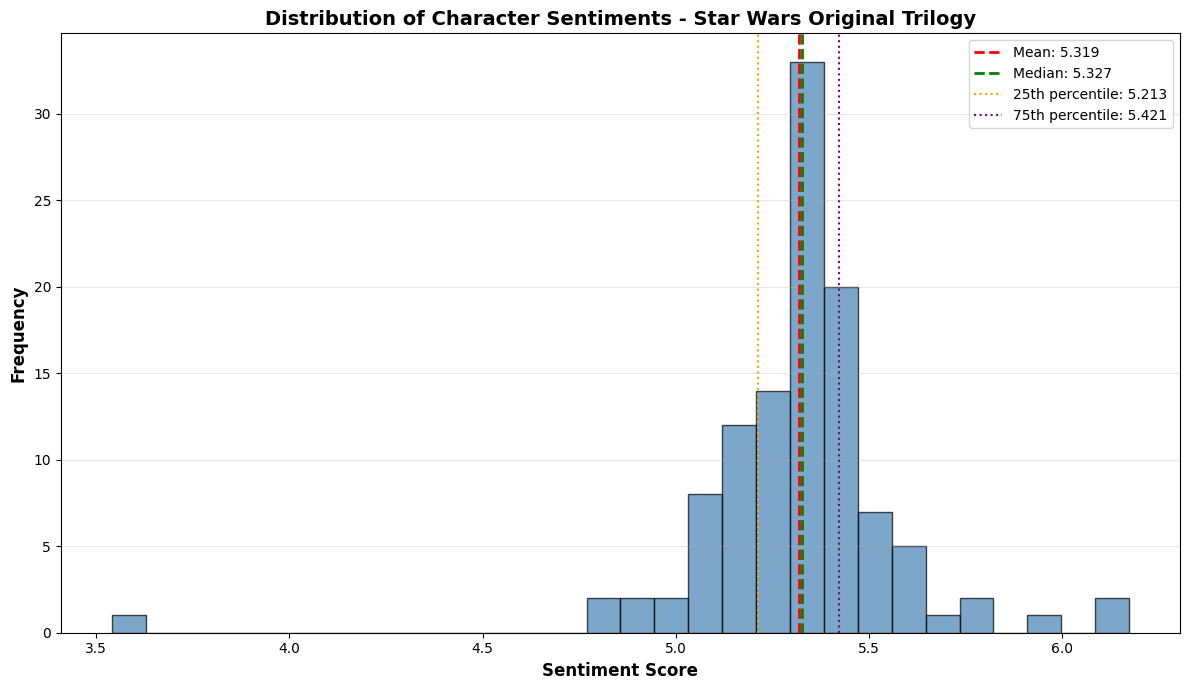


Character Sentiment Statistics:
  Total characters analyzed: 112
  Mean: 5.319
  Median: 5.327
  Std Dev: 0.271
  Min: 3.540
  Max: 6.173


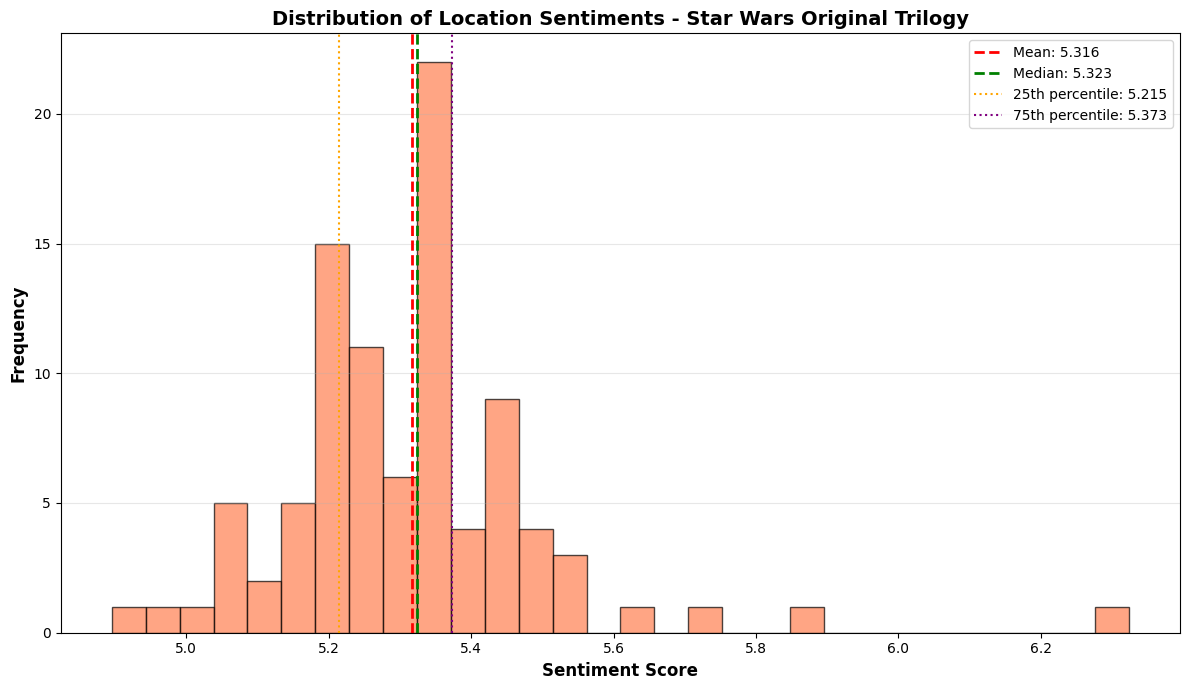


Location Sentiment Statistics:
  Total locations analyzed: 93
  Mean: 5.316
  Median: 5.323
  Std Dev: 0.183
  Min: 4.895
  Max: 6.324


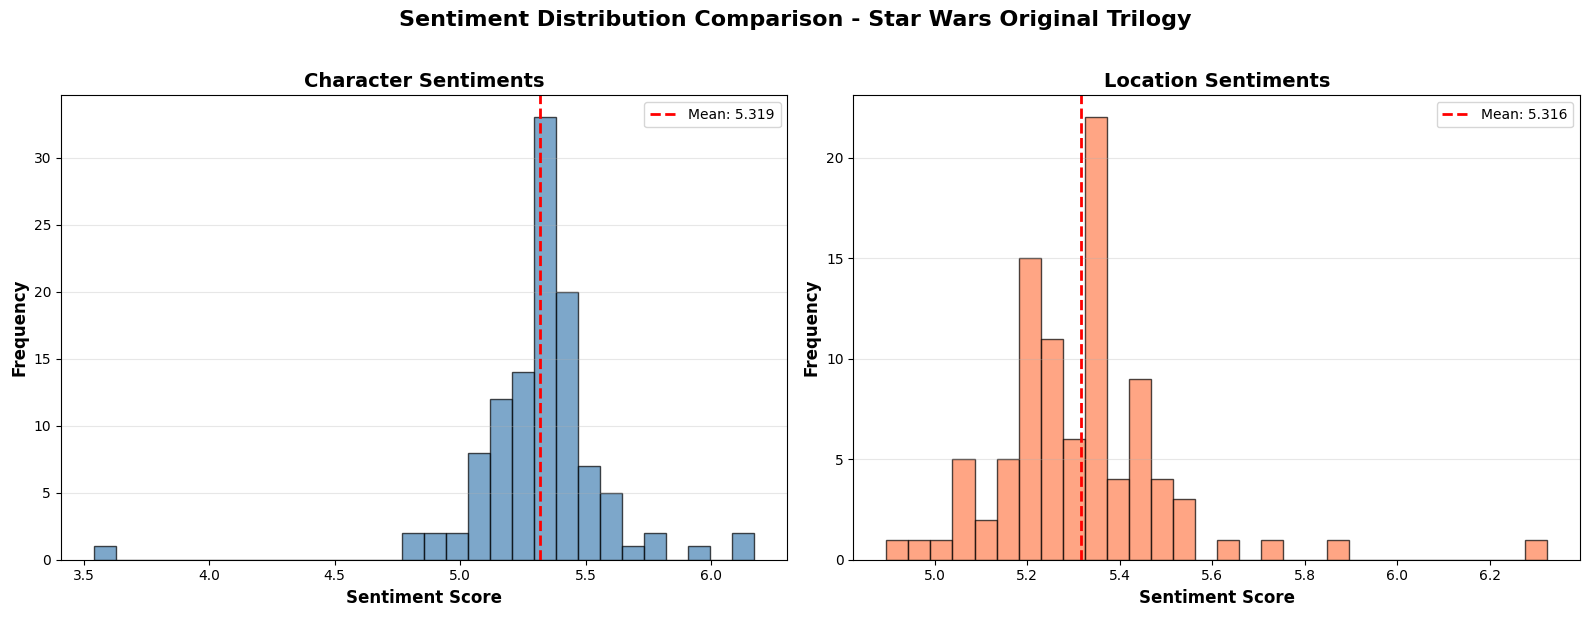

In [160]:
import numpy as np
import matplotlib.pyplot as plt

figures_dir = './figures'
# Extract character sentiments (excluding None values)
character_sentiments = [
    data["sentiment"] for data in character_connections_dict.values() 
    if data["sentiment"] is not None
]

# Extract location sentiments (excluding None values)
location_sentiments = [
    data["sentiment"] for data in location_characters_dict.values() 
    if data["sentiment"] is not None
]

# Plot Character Sentiment Distribution
if character_sentiments:
    mean_sentiment = round(np.mean(character_sentiments), 4)
    median_sentiment = round(np.median(character_sentiments), 4)
    p25_sentiment = round(np.percentile(character_sentiments, 25), 4)
    p75_sentiment = round(np.percentile(character_sentiments, 75), 4)
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Histogram
    ax.hist(character_sentiments, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
    
    # Add vertical lines for statistics
    ax.axvline(mean_sentiment, color="red", linestyle="--", linewidth=2, 
               label=f"Mean: {mean_sentiment:.3f}")
    ax.axvline(median_sentiment, color="green", linestyle="--", linewidth=2, 
               label=f"Median: {median_sentiment:.3f}")
    ax.axvline(p25_sentiment, color="orange", linestyle=":", linewidth=1.5, 
               label=f"25th percentile: {p25_sentiment:.3f}")
    ax.axvline(p75_sentiment, color="purple", linestyle=":", linewidth=1.5,
               label=f"75th percentile: {p75_sentiment:.3f}")
    
    # Labels and title
    ax.set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
    ax.set_title("Distribution of Character Sentiments - Star Wars Original Trilogy", 
                 fontsize=14, fontweight="bold")
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(figures_dir + "/character_sentiment_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nCharacter Sentiment Statistics:")
    print(f"  Total characters analyzed: {len(character_sentiments)}")
    print(f"  Mean: {mean_sentiment:.3f}")
    print(f"  Median: {median_sentiment:.3f}")
    print(f"  Std Dev: {np.std(character_sentiments):.3f}")
    print(f"  Min: {np.min(character_sentiments):.3f}")
    print(f"  Max: {np.max(character_sentiments):.3f}")

# Plot Location Sentiment Distribution
if location_sentiments:
    mean_sentiment = round(np.mean(location_sentiments), 4)
    median_sentiment = round(np.median(location_sentiments), 4)
    p25_sentiment = round(np.percentile(location_sentiments, 25), 4)
    p75_sentiment = round(np.percentile(location_sentiments, 75), 4)
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Histogram
    ax.hist(location_sentiments, bins=30, color="coral", edgecolor="black", alpha=0.7)
    
    # Add vertical lines for statistics
    ax.axvline(mean_sentiment, color="red", linestyle="--", linewidth=2, 
               label=f"Mean: {mean_sentiment:.3f}")
    ax.axvline(median_sentiment, color="green", linestyle="--", linewidth=2, 
               label=f"Median: {median_sentiment:.3f}")
    ax.axvline(p25_sentiment, color="orange", linestyle=":", linewidth=1.5, 
               label=f"25th percentile: {p25_sentiment:.3f}")
    ax.axvline(p75_sentiment, color="purple", linestyle=":", linewidth=1.5,
               label=f"75th percentile: {p75_sentiment:.3f}")
    
    # Labels and title
    ax.set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
    ax.set_title("Distribution of Location Sentiments - Star Wars Original Trilogy", 
                 fontsize=14, fontweight="bold")
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(figures_dir + "/location_sentiment_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nLocation Sentiment Statistics:")
    print(f"  Total locations analyzed: {len(location_sentiments)}")
    print(f"  Mean: {mean_sentiment:.3f}")
    print(f"  Median: {median_sentiment:.3f}")
    print(f"  Std Dev: {np.std(location_sentiments):.3f}")
    print(f"  Min: {np.min(location_sentiments):.3f}")
    print(f"  Max: {np.max(location_sentiments):.3f}")

# Optional: Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Character sentiments
if character_sentiments:
    axes[0].hist(character_sentiments, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
    axes[0].axvline(np.mean(character_sentiments), color="red", linestyle="--", linewidth=2, 
                    label=f"Mean: {np.mean(character_sentiments):.3f}")
    axes[0].set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
    axes[0].set_title("Character Sentiments", fontsize=14, fontweight="bold")
    axes[0].legend(fontsize=10)
    axes[0].grid(axis="y", alpha=0.3)

# Location sentiments
if location_sentiments:
    axes[1].hist(location_sentiments, bins=30, color="coral", edgecolor="black", alpha=0.7)
    axes[1].axvline(np.mean(location_sentiments), color="red", linestyle="--", linewidth=2, 
                    label=f"Mean: {np.mean(location_sentiments):.3f}")
    axes[1].set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    axes[1].set_ylabel("Frequency", fontsize=12, fontweight="bold")
    axes[1].set_title("Location Sentiments", fontsize=14, fontweight="bold")
    axes[1].legend(fontsize=10)
    axes[1].grid(axis="y", alpha=0.3)

plt.suptitle("Sentiment Distribution Comparison - Star Wars Original Trilogy", 
             fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(figures_dir + "/sentiment_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [163]:
# TF-IDF on character dialogues
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Build a document for each character
character_names = list(normalized_character_dialogues.keys())
character_docs = [" ".join(normalized_character_dialogues[c]) for c in character_names]

# Create TF-IDF
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.7,     # ignore words used in 70%+ of characters
    min_df=2,       # must appear in at least 2 characters
    ngram_range=(1,2)  # unigrams + bigrams
)

tfidf_matrix = vectorizer.fit_transform(character_docs)
feature_names = np.array(vectorizer.get_feature_names_out())

def top_tfidf_words(matrix_row, top_n=10):
    row_data = matrix_row.toarray().flatten()
    top_indices = row_data.argsort()[::-1][:top_n]
    return [(feature_names[i], row_data[i]) for i in top_indices]

character_tfidf = {}

for idx, character in enumerate(character_names):
    character_tfidf[character] = top_tfidf_words(tfidf_matrix[idx], top_n=15)

for char, words in character_tfidf.items():
    print(f"\nCharacter: {char}")
    for word, score in words:
        print(f"  {word}: {score:.4f}")



location_names = list(normalized_location_dialogues.keys())
location_docs = [" ".join(normalized_location_dialogues[l]) for l in location_names]

loc_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.7,
    min_df=2,
    ngram_range=(1,2)
)

loc_tfidf_matrix = loc_vectorizer.fit_transform(location_docs)
loc_feature_names = np.array(loc_vectorizer.get_feature_names_out())

def top_location_tfidf_words(matrix_row, top_n=10):
    row_data = matrix_row.toarray().flatten()
    top_indices = row_data.argsort()[::-1][:top_n]
    return [(loc_feature_names[i], row_data[i]) for i in top_indices]

location_tfidf = {}

for idx, loc in enumerate(location_names):
    location_tfidf[loc] = top_location_tfidf_words(loc_tfidf_matrix[idx], top_n=15)


def word_sentiment(word):
    try:
        return sentiment_score(word)
    except:
        return 0.0


character_refined_sentiment = {}



for char, words in character_tfidf.items():
    if not words:  # None or empty list
        character_refined_sentiment[char] = 0
        continue

    total_weight = 0.0
    weighted_sentiment = 0.0
    
    for word, tfidf_val in words:
        if word is None or tfidf_val is None:
            continue

        try:
            tfidf_val = float(tfidf_val)
        except:
            continue
        
        if tfidf_val <= 0:
            continue

        s = word_sentiment(word)
        if s is None:
            continue

        weighted_sentiment += s * tfidf_val
        total_weight += tfidf_val
    
    character_refined_sentiment[char] = (
        weighted_sentiment / total_weight if total_weight > 0 else 0
    )



Character: C-3PO
  artoo: 0.3204
  han: 0.2781
  threepio: 0.2660
  luke: 0.2553
  chewie: 0.2530
  leia: 0.2046
  jabba: 0.1415
  oh: 0.1211
  don: 0.0999
  lando: 0.0951
  door: 0.0917
  ewoks: 0.0908
  little: 0.0825
  going: 0.0825
  looks: 0.0783

Character: Luke Skywalker
  luke: 0.6057
  artoo: 0.1979
  han: 0.1685
  ben: 0.1431
  leia: 0.1260
  vader: 0.1143
  chewie: 0.1109
  yoda: 0.1002
  father: 0.0936
  threepio: 0.0930
  looks: 0.0919
  don: 0.0898
  jedi: 0.0820
  ll: 0.0805
  little: 0.0765

Character: Imperial Officer
  chewie: 0.2533
  stop: 0.1297
  han: 0.1234
  platform: 0.1229
  vader: 0.1176
  wookiee: 0.1081
  leia: 0.1037
  officer: 0.0961
  arm: 0.0865
  turns: 0.0863
  pirate: 0.0856
  chewbacca: 0.0790
  stormtroopers: 0.0779
  boba fett: 0.0754
  fett: 0.0754

Character: Rebel Officer
  officer: 0.1789
  plans: 0.1681
  intercepted: 0.1620
  consular: 0.1620
  ambassador: 0.1620
  consular ship: 0.1620
  vader: 0.1563
  soldier: 0.1419
  rebel: 0.1406
  re


🎭 Top 10 Happiest Characters:
  Gold Leader: 6.6700
  Bunker Commander: 6.2894
  Needa: 6.2174
  Bib: 6.1386
  Piett: 6.1372
  Veers: 6.1039
  Ozzel: 6.0803
  Tracking Officer: 6.0693
  Communications Officer: 6.0693
  Base Voice: 6.0311

😢 Top 10 Saddest Characters:
  Oola: 4.3670
  Officer Cass: 4.3950
  Boushh: 4.4129
  Jabba: 4.8577
  Intercom Voice: 4.8716
  Imperial Officer: 4.8793
  Senior Controller: 4.9274
  Chief Pilot: 4.9530
  Red Ten: 4.9951
  Woman: 5.0250


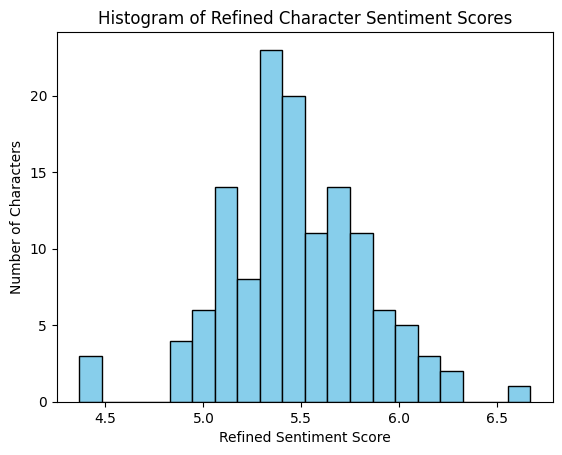

In [165]:
# Filter out None values
char_sent_list = [
    (char, s) for char, s in character_refined_sentiment.items()
    if s is not None
]

print("\n🎭 Top 10 Happiest Characters:")
for char, s in sorted(char_sent_list, key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {char}: {s:.4f}")

print("\n😢 Top 10 Saddest Characters:")
for char, s in sorted(char_sent_list, key=lambda x: x[1])[:10]:
    print(f"  {char}: {s:.4f}")

# plot refined character sentiments histogram
refined_char_scores = [s for s in character_refined_sentiment.values() if s is not None]
plt.hist(refined_char_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Refined Character Sentiment Scores')
plt.xlabel('Refined Sentiment Score')
plt.ylabel('Number of Characters')
plt.show()

In [171]:
# Count total words spoken by each character
character_word_counts = {
    char: sum(len(dialogue.split()) for dialogue in dialogues)
    for char, dialogues in normalized_character_dialogues.items()
}
# Characters with more than 200 words AND a valid refined sentiment
filtered_chars = [
    (char, character_refined_sentiment.get(char))
    for char, wc in character_word_counts.items()
    if wc > 500 and character_refined_sentiment.get(char) is not None
]
print("\n🎭 Top 10 Happiest Characters (500+ words):")
for char, s in sorted(filtered_chars, key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {char}: {s:.4f} ({character_word_counts[char]} words)")

print("\n😢 Top 10 Saddest Characters (500+ words):")
for char, s in sorted(filtered_chars, key=lambda x: x[1])[:10]:
    print(f"  {char}: {s:.4f} ({character_word_counts[char]} words)")



🎭 Top 10 Happiest Characters (500+ words):
  Gold Leader: 6.6700 (514 words)
  Bib: 6.1386 (542 words)
  Piett: 6.1372 (1530 words)
  Ozzel: 6.0803 (513 words)
  Owen Lars: 6.0233 (1407 words)
  Beru Lars: 5.9502 (2259 words)
  Red Leader: 5.9501 (1120 words)
  Wedge Antilles: 5.9309 (1532 words)
  Lure: 5.8904 (640 words)
  Gantry Officer: 5.8393 (909 words)

😢 Top 10 Saddest Characters (500+ words):
  Oola: 4.3670 (708 words)
  Boushh: 4.4129 (1268 words)
  Jabba: 4.8577 (1760 words)
  Intercom Voice: 4.8716 (674 words)
  Imperial Officer: 4.8793 (992 words)
  Ackbar: 5.0493 (1219 words)
  Boba Fett: 5.0702 (1025 words)
  Officer: 5.0864 (839 words)
  C-3PO: 5.0901 (24947 words)
  First Trooper: 5.1084 (619 words)
